## Theory
Define a simple linear model for the MRI signal $s$:
* define a signal $s_0$ at $t=0$; assume that $\newcommand\etco{\mathit{ETCO2}} \newcommand\cvr{\mathit{CVR}}\etco=\etco_0$ for long enough that a steady-state signal has been reached.
* $\cvr$ is the change in $s$ (as a fraction of $s_0$) per unit change in $ETCO2$
* there is a drift $d$ that causes a change in $s$ (as a fraction of $s_0$) per unit time
* there is a delay $\delta$ such that the signal depends on $\etco(t-\delta)$

Therefore, $ s = s_0 + \cvr\cdot\left(\etco(t-\delta)-\etco_0\right)\cdot s_0 + d\cdot t\cdot s_0$.  
Rearranging, $$ s = s_0\cdot(1-\cvr\cdot\etco_0) + \cvr\cdot s_0\cdot\etco(t-\delta) + d\cdot s_0\cdot t$$
Using multiple linear regression we obtain an intercept and a coefficient for each regressor:
* $\beta_0 = s_0 (1-\cvr\,\etco_0)$
* $\beta_\etco = \cvr\,s_0$
* $\beta_t = d\,s_0$

So, $\cvr=\frac{\beta_\etco}{s_0}$. We've defined $s_0$ as the signal at $t=0$, however for noisy data it may be more reliable to take the average signal over multiple early time points.

## Define Python functions

In [2]:
import ipywidgets as widgets
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

%matplotlib inline

def delay_etco2(etco2, delay):
    # apply a delay to etco2 time course
    # etco2 = ETCO2 array, delay = delay (points)
    # returns: shifted ETCO2 array

    # shift etco2
    etco2_shifted = np.roll(etco2, delay)
    
    # above step is circular shift - correct start/end values (simplistic)
    if delay > 0:
        etco2_shifted[:delay] = etco2[0]
    elif delay < 0:
        etco2_shifted[delay::] = etco2[-1]
    
    return etco2_shifted


def gen_cvr_signal(etco2, s0, cvr, delay = 0, sigma = 0, drift = 0, n = 1):
    # simulate multiple CVR signals
    # etco2 = ETCO2 array, s0 = signal at time zero, cvr = CVR (%/mmHg), delay (points), sigma = std of Gaussian noise, drift = signal drift / s0 per unit time, n = number of signals to generate
    # returns a 2D array; one signal per column

    # shift etco2
    etco2_shifted = delay_etco2(etco2, delay)
    
    # generate the pure signals
    s = np.tile( s0 * (1 + (cvr/100)*(etco2_shifted - etco2[0])), [n, 1] )
    
    # add drift
    t = np.arange(etco2.size)
    
    s += (drift/100.) * t * s0
    
    # add noise
    s += np.random.normal(loc = 0., scale = sigma, size = s.shape)
    
    s = s.transpose()
    
    return s # each signal is a column


def fit_cvr(etco2, s, delay = 0, baseline = [0]):
    # fit CVR signal(s) with a specified delay
    # etco2 = ETCO2 array, s = array of signals (one column per signal), delay = delay (points), baseline = list of indices to use to estimate s0
    # returns dict of results {cvr, drift, residuals}; each entry is an array contain 1 value per signal analysed
   
    # shift etco2
    etco2_shifted = delay_etco2(etco2, delay)
    
    # organise regressors into matrix
    a1 = np.ones(etco2_shifted.shape).reshape(-1,1)
    a2 = etco2_shifted.reshape(-1,1)
    a3 = np.arange(etco2.size).reshape(-1,1)
    regs = np.concatenate((a1,a2,a3),1) # matrix with n rows and 2 columns (ones and shifted etco2)
    
    # do multiple linear regression
    x, residuals, rank, svs = np.linalg.lstsq(regs, s, rcond=None)
    s0 = np.mean(s[baseline], axis=0)
    cvr = (100. * x[1]) / s0
    drift = (100. * x[2]) / s0
    
    results = {'cvr': cvr, 'drift': drift, 'res': residuals}
    
    return results


def fit_cvr_delay(etco2, s, min_delay=0, max_delay=0, baseline = [0]):
    # fit CVR signal(s) with optimised delay
    # etco2 = ETCO2 array, s = array of signals (one column per signal), min/max_delay = min/max allowed delay (points), baseline = list of indices to use to estimate s0
    # returns dict of results {cvr, delay, drift, residuals}; each entry is an array contain 1 value per signal analysed
    
    cvr, delay, drift, res = [], [], [], []
    for signal in s.transpose():
        delay_range = range(min_delay, max_delay + 1)
        
        results_all_shifts = [ fit_cvr(etco2, signal, this_delay, baseline = baseline) for this_delay in delay_range ]

        residuals = [ result['res'][0] for result in results_all_shifts ]
        res_best = min(residuals)
        idx_best = residuals.index(res_best)
        
        cvr.append(results_all_shifts[idx_best]['cvr'])        
        delay.append(delay_range[idx_best])
        drift.append(results_all_shifts[idx_best]['drift'])
        res.append(res_best)
        
    results = { 'cvr': cvr, 'delay': delay, 'drift': drift, 'res': res }
    
    return results

## Do some simulations
### Set up a paradigm

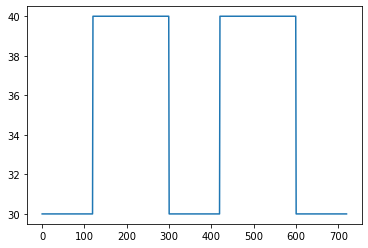

In [3]:
etco2_mss3 = np.concatenate((30.*np.ones(120), 40.*np.ones(180), 30.*np.ones(120), 40.*np.ones(180), 30.*np.ones(120)))
p = plt.plot(etco2_mss3)

### Generate and fit MRI signals

mean CVR: 0.04001365530413544, std CVR: 0.001675312412216947
mean delay: 19.95, std delay: 0.2958039891549808


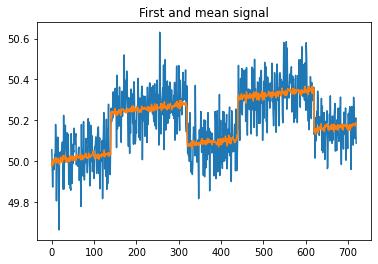

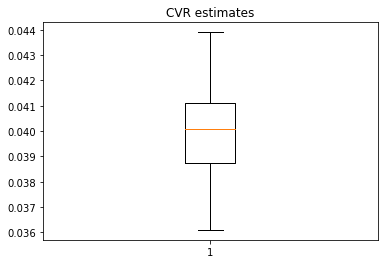

In [4]:
s0, cvr, delay = 50, 0.04, 20
n, sigma, drift = 100, 0.1, 0.0005

# generate signals
s = gen_cvr_signal(etco2_mss3, s0, cvr, delay = delay, sigma = sigma, drift = drift, n = n)

# plot signals
fig, ax = plt.subplots()
ax.plot(s[:,0]);
ax.plot(np.mean(s, axis=1));
ax.set_title('First and mean signal');

# fit sigals
results = fit_cvr_delay(etco2_mss3, s, min_delay=-100, max_delay=100, baseline=list(range(10)))

# plot results
fig, ax = plt.subplots()
bp = ax.boxplot(results['cvr']);
ax.set_title('CVR estimates');
print("mean CVR: {mean}, std CVR: {std}".format(mean=np.mean(results['cvr']), std=np.std(results['cvr'])))
print("mean delay: {mean}, std delay: {std}".format(mean=np.mean(results['delay']), std=np.std(results['delay'])))

### Interactive simulation

In [5]:
# interactive plot for fitting results
%matplotlib widget

etco2, n = etco2_mss3, 100

@widgets.interact(s0 = (0, 100, 1), cvr = (0, 0.1, 0.005), delay = (-30, 30, 1), sigma = (0, 0.5, 0.025), drift = (0, 0.001, 0.0001))
def fit_signals(s0 = 50, cvr = 0.04 , delay = 20, sigma = 0.1, drift = 0.0005):
    # generate signals
    s = gen_cvr_signal(etco2, s0, cvr, delay = delay, sigma = sigma, drift = drift, n = n)
    
    # plot signals
    if plt.fignum_exists(10):
        plt.close(10)    
    fig, ax = plt.subplots(1,2)
    ax[0].plot(s[:,0]);
    ax[0].plot(np.mean(s, axis=1));
    ax[0].set_title('First and mean signal');
    
    # fit signals
    results = fit_cvr_delay(etco2_mss3, s, min_delay=-40, max_delay=40, baseline=list(range(10)))
    #print("mean CVR: {mean}, std CVR: {std}".format(mean=np.mean(results['cvr']), std=np.std(results['cvr'])))
    #print("mean delay: {mean}, std delay: {std}".format(mean=np.mean(results['delay']), std=np.std(results['delay'])))
    ax[1].set_title('CVR estimates');
    ax[1].set_ylim([0,0.1])
    ax[1].boxplot(results['cvr']);

interactive(children=(IntSlider(value=50, description='s0'), FloatSlider(value=0.04, description='cvr', max=0.…

In [97]:
plt.close('all')